In [3]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from pycaret.classification import *
import matplotlib.pyplot as plt

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1
3,TRAIN_00003,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지,1
4,TRAIN_00004,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소,2


In [6]:
train.drop('ID', axis = 1, inplace=True)
test.drop('ID', axis = 1, inplace=True)
ordinal_features = ['요일', '범죄발생지']
for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[feature] = le.transform(test[feature])

In [7]:
clf = setup(data=train, 
            target='TARGET', 
            normalize=True,                      
            # polynomial_features=True,
            session_id=42, 
            use_gpu =True
            ) 

In [14]:
top3 = compare_models(sort='f1', n_select=5, fold=5)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:34:27
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [15]:
result = pull()
display(result)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5461,0.6989,0.5461,0.5418,0.5358,0.2840,0.2894,3.138
gbc,Gradient Boosting Classifier,0.5454,0.6957,0.5454,0.5424,0.5347,0.2826,0.2885,16.822
ada,Ada Boost Classifier,0.5391,0.6861,0.5391,0.5363,0.5288,0.2743,0.2796,2.076
rf,Random Forest Classifier,0.5202,0.6705,0.5202,0.5121,0.5093,0.2437,0.2477,2.768
et,Extra Trees Classifier,0.4989,0.6492,0.4989,0.4894,0.4891,0.2127,0.2154,2.696
qda,Quadratic Discriminant Analysis,0.4632,0.6161,0.4632,0.4617,0.4569,0.1708,0.1726,0.350
nb,Naive Bayes,0.4535,0.6135,0.4535,0.4607,0.4425,0.1614,0.1665,0.316
dt,Decision Tree Classifier,0.4327,0.5657,0.4327,0.4341,0.4334,0.1312,0.1313,0.682
knn,K Neighbors Classifier,0.4516,0.5887,0.4516,0.4328,0.4301,0.1253,0.1298,1.796
lr,Logistic Regression,0.4555,0.6005,0.4555,0.4172,0.3870,0.0931,0.1134,0.376


In [16]:
blended = blend_models(estimator_list = top3[:3], fold = 5, weights=[0.5,0.3,0.2])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:39:01
Status,. . . . . . . . . . . . . . . . . .,Compiling Estimators
Estimator,. . . . . . . . . . . . . . . . . .,Voting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5456,0.6970,0.5456,0.5422,0.5347,0.2823,0.2883
1,0.5440,0.7012,0.5440,0.5395,0.5341,0.2815,0.2865
2,0.5471,0.6980,0.5471,0.5444,0.5371,0.2859,0.2915
3,0.5484,0.7008,0.5484,0.5433,0.5371,0.2868,0.2927
4,0.5466,0.6988,0.5466,0.5434,0.5359,0.2841,0.2901
Mean,0.5464,0.6992,0.5464,0.5426,0.5358,0.2841,0.2898
Std,0.0015,0.0016,0.0015,0.0017,0.0012,0.0020,0.0022


In [17]:
# Initiate classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'multiclass', 
          n_jobs = -1, 
          max_depth = -1,
          device= 'gpu',
          min_split_gain = 0.5,
          random_state = 42 )

In [14]:
x_train = train.drop(['TARGET'], axis = 1)
y_train = train['TARGET']

In [ ]:
gridParams = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [64,256],
    'num_leaves': [16,32], 
    'boosting_type' : ['gbdt', 'dart'], 
    'colsample_bytree' : [0.5, 0.75, 1.],
    'subsample' : [0.5, 0.75, 1.],
    'reg_alpha' : [0.,0.5],
    'reg_lambda' : [0.,0.5],
    }

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

In [ ]:
gridParams = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [64],
    'num_leaves': [32],
    'colsample_bytree' : [0.75],
    'min_split_gain' : [0.,0.5,1],
    'subsample' : [0.5, 0.6,],
    'reg_alpha' : [0.25,0.5,0.75],
    }

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=4)
grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

<AxesSubplot:>

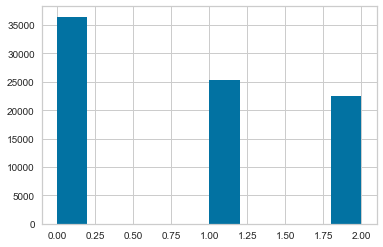

In [10]:
train['TARGET'].hist()

In [12]:
#classweight
mdl = lgb.LGBMClassifier(boosting_type= 'dart', 
                        objective = 'multiclass', 
                        n_jobs = 5, 
                        colsample_bytree =0.75,
                        min_split_gain =.5,
                        n_estimators=2048,
                        reg_alpha =.75,
                        subsample =.5,
                        max_depth = -1,
                        device= 'gpu',
                        random_state = 42,
                        class_weight='balanced',
                        num_leaves = 256
            )

In [15]:
mdl.fit(x_train,y_train)

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.75, device='gpu', importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.5, n_estimators=2048,
               n_jobs=5, num_leaves=256, objective='multiclass',
               random_state=42, reg_alpha=0.75, reg_lambda=0.0, silent='warn',
               subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

In [19]:
pred = mdl.predict(test)
pred

array([2, 0, 0, ..., 1, 0, 1], dtype=int64)

In [17]:
submit = pd.read_csv('../data/sample_submission.csv')
submit['TARGET'] = pred
submit.head()

In [21]:
submit.to_csv('../submit/lightgbm4.csv', index=False)

,ID,TARGET
0,TEST_00000,2
1,TEST_00001,0
2,TEST_00002,0
3,TEST_00003,0
4,TEST_00004,0
...,...,...
17284,TEST_17284,1
17285,TEST_17285,0
17286,TEST_17286,1
17287,TEST_17287,0
